<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://goo.gl/rvvZiR).**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

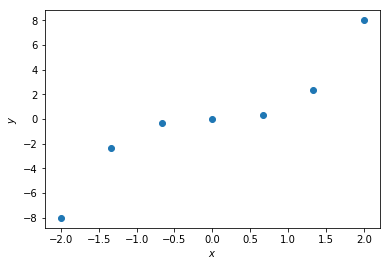

In [2]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график.

7


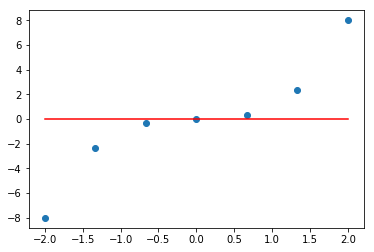

In [3]:
plt.scatter(X, y)
plt.plot(X, [np.mean(y)]*len(X), 'r')

print(len(X))

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

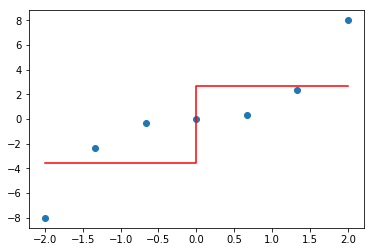

In [4]:
x1 = X[X < 0]
x2 = X[X >= 0]
y1 = [np.mean(y[X < 0])]*len(x1)
y2 = [np.mean(y[X >= 0])]*len(x2)
plt.scatter(X, y)
plt.plot(np.concatenate((np.linspace(-2, 0, len(y1)), np.linspace(0, 2, len(y2)))), np.concatenate((y1, y2)), 'r')

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [5]:
def dispersion(y):
    return np.sum((y - np.mean(y))**2)/len(y)

def regression_var_criterion(X, y, t):
    X_left = X[X < t]
    X_right = X[X >= t]
    y_left = y[X < t]
    y_right = y[X >= t]
    return dispersion(y) - (len(X_left)/len(X))*dispersion(y_left) - (len(X_right)/len(X))*dispersion(y_right)

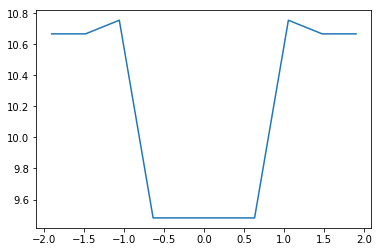

In [6]:
t = np.linspace(-1.9, 1.9, 10)
Q = list(map(lambda tt: regression_var_criterion(X, y, tt), t))
plt.plot(t, Q)

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

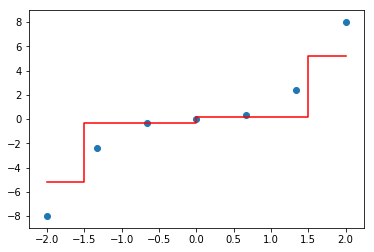

In [7]:
def get_line(period, y):
    x = np.linspace(period[0], period[1], 10)
    mean = np.mean(y)
    return (x, [mean]*len(x))
    
l1 = get_line([-2, -1.5], y[y < -1.5])
l2 = get_line([-1.5, 0], y[(-1.5 <= y) & (y < 0)])
l3 = get_line([0, 1.5], y[(0 <= y) & (y < 1.5)])
l4 = get_line([1.5, 2], y[y >= 1.5])
plt.plot(np.hstack((l1[0], l2[0], l3[0], l4[0])), np.hstack((l1[1], l2[1], l3[1], l4[1])), 'r')
plt.scatter(X, y)

**<font color='red'>Вопрос 2.</font> Из скольки отрезков состоит график, изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- **7**
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [8]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [9]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах", а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`.

In [10]:
df['years_age'] = df['age'].apply(lambda x: round(x/365.25))
cholesterol_df = pd.get_dummies(df['cholesterol']).rename(columns=lambda col: 'cholesterol_' + str(col))
gluc_df = pd.get_dummies(df['gluc']).rename(columns=lambda col: 'gluc_' + str(col))
df[cholesterol_df.columns] = cholesterol_df
df[gluc_df.columns] = gluc_df
df = df.drop(['age', 'gluc', 'cholesterol'], axis=1)
df.head()

,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,years_age,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,
0,2,168,62.0,110,80,0,0,1,0,50,1,0,0,1,0,0
1,1,156,85.0,140,90,0,0,1,1,55,0,0,1,1,0,0
2,1,165,64.0,130,70,0,0,0,1,52,0,0,1,1,0,0
3,2,169,82.0,150,100,0,0,1,1,48,1,0,0,1,0,0
4,1,156,56.0,100,60,0,0,0,0,48,1,0,0,1,0,0


In [11]:
y = df['cardio']
X = df.drop('cardio', axis=1)

Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [13]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')

In [14]:
export_graphviz(tree, feature_names=X.columns, out_file='../../img/churn_tree.dot', filled=True)

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- **age, ap_hi, chol=3**

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [15]:
y_pred = tree.predict(X_valid)
accuracy_score(y_valid, y_pred)

0.72538095238095235

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [16]:
tree_params = {'max_depth': list(range(2, 11)), 'random_state': [17]}
tree = DecisionTreeClassifier()
tree_grid = GridSearchCV(tree, tree_params, cv=5)
tree_grid.fit(X_train, y_train)
tree_grid.best_params_

{'max_depth': 6, 'random_state': 17}

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

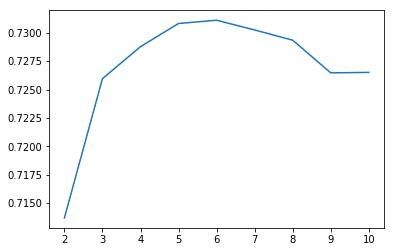

In [17]:
plt.plot([x['max_depth'] for x in tree_grid.cv_results_['params']], [x for x in tree_grid.cv_results_['mean_test_score']])

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [18]:
print(tree_grid.best_params_)
print(accuracy_score(y_valid, tree_grid.best_estimator_.predict(X_valid)))

{'max_depth': 6, 'random_state': 17}
0.729142857143


**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева четкий пик, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке?**
- да, да
- да, нет
- нет, да
- **нет, нет**

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках.

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 16 columns):
gender           70000 non-null int64
height           70000 non-null int64
weight           70000 non-null float64
ap_hi            70000 non-null int64
ap_lo            70000 non-null int64
smoke            70000 non-null int64
alco             70000 non-null int64
active           70000 non-null int64
cardio           70000 non-null int64
years_age        70000 non-null int64
cholesterol_1    70000 non-null uint8
cholesterol_2    70000 non-null uint8
cholesterol_3    70000 non-null uint8
gluc_1           70000 non-null uint8
gluc_2           70000 non-null uint8
gluc_3           70000 non-null uint8
dtypes: float64(1), int64(9), uint8(6)
memory usage: 8.8 MB


In [20]:
df_clean = df[(df['years_age'] >= 45) & (df['years_age'] < 65) & (df['ap_hi'] >= 120) & (df['ap_hi'] < 180)]
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48943 entries, 1 to 99999
Data columns (total 16 columns):
gender           48943 non-null int64
height           48943 non-null int64
weight           48943 non-null float64
ap_hi            48943 non-null int64
ap_lo            48943 non-null int64
smoke            48943 non-null int64
alco             48943 non-null int64
active           48943 non-null int64
cardio           48943 non-null int64
years_age        48943 non-null int64
cholesterol_1    48943 non-null uint8
cholesterol_2    48943 non-null uint8
cholesterol_3    48943 non-null uint8
gluc_1           48943 non-null uint8
gluc_2           48943 non-null uint8
gluc_3           48943 non-null uint8
dtypes: float64(1), int64(9), uint8(6)
memory usage: 4.4 MB


In [21]:
df_clean['years_age'].describe()

count    48943.000000
mean        55.446274
std          5.147016
min         45.000000
25%         52.000000
50%         56.000000
75%         60.000000
max         64.000000
Name: years_age, dtype: float64

In [22]:
df_clean.head()

,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,years_age,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,
1,1,156,85.0,140,90,0,0,1,1,55,0,0,1,1,0,0
2,1,165,64.0,130,70,0,0,0,1,52,0,0,1,1,0,0
3,2,169,82.0,150,100,0,0,1,1,48,1,0,0,1,0,0
8,1,151,67.0,120,80,0,0,0,0,60,0,1,0,0,1,0
9,1,157,93.0,130,80,0,0,1,0,61,0,0,1,1,0,0


In [27]:
def map_age(age):
    if 45 <= age < 50:
        return 1
    elif 50 <= age < 55:
        return 2
    elif 55 <= age < 60:
        return 3
    elif 60 <= age < 65:
        return 4
    
def map_ap_hi(ap_hi):
    if 120 <= ap_hi < 140:
        return 1
    elif 140 <= ap_hi < 160:
        return 2
    elif 160 <= ap_hi < 180:
        return 3
    


df_new = pd.DataFrame()
age_range_df = pd.get_dummies(df_clean['years_age'].map(map_age)).rename(columns=lambda x: 'age_' + str(x))
df_new[age_range_df.columns] = age_range_df

ap_hi_range_df = pd.get_dummies(df_clean['ap_hi'].map(map_ap_hi)).rename(columns=lambda x: 'ap_hi_' + str(x))
df_new[ap_hi_range_df.columns] = ap_hi_range_df

df_new[['cholesterol_1', 'cholesterol_2', 'cholesterol_3']] = df_clean[['cholesterol_1', 'cholesterol_2', 'cholesterol_3']]

df_new['male'] = df_clean['gender'].map({1: 0, 2: 1})

df_new['smoke'] = df_clean['smoke']

y = df_clean['cardio']
X = df_new


tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')

In [28]:
export_graphviz(tree, feature_names=X.columns, out_file='../../img/bin_tree.dot', filled=True)

In [29]:
!dot -Tpng ../../img/bin_tree.dot -o ../../img/bin_tree.png

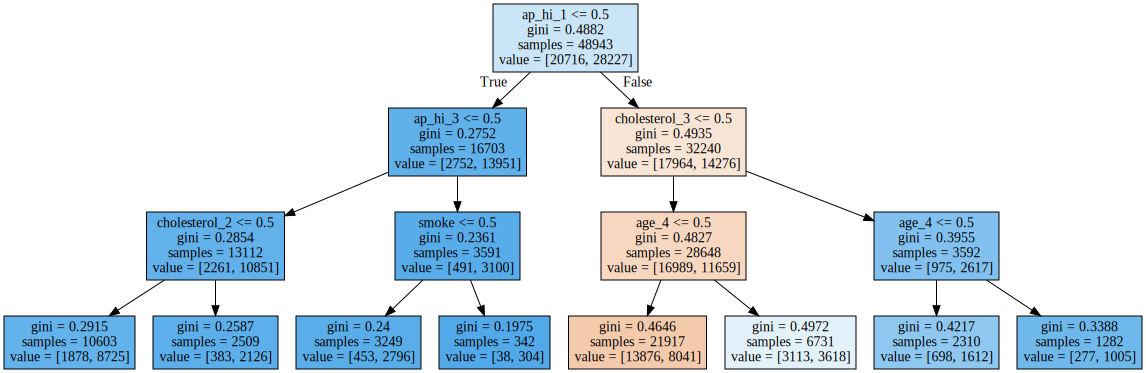

In [30]:
import graphviz as gv
gv.Source((export_graphviz(tree, feature_names=X.columns, out_file=None, filled=True)))

In [31]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48943 entries, 1 to 99999
Data columns (total 12 columns):
age_1            48943 non-null uint8
age_2            48943 non-null uint8
age_3            48943 non-null uint8
age_4            48943 non-null uint8
ap_hi_1          48943 non-null uint8
ap_hi_2          48943 non-null uint8
ap_hi_3          48943 non-null uint8
cholesterol_1    48943 non-null uint8
cholesterol_2    48943 non-null uint8
cholesterol_3    48943 non-null uint8
male             48943 non-null int64
smoke            48943 non-null int64
dtypes: int64(2), uint8(10)
memory usage: 1.6 MB


In [31]:

pd.Series(data=tree.feature_importances_, index=X.columns).sort_values(ascending=False)

ap_hi_1          0.775268
cholesterol_3    0.151027
age_4            0.071390
ap_hi_3          0.001644
cholesterol_2    0.000556
smoke            0.000114
male             0.000000
cholesterol_1    0.000000
ap_hi_2          0.000000
age_3            0.000000
age_2            0.000000
age_1            0.000000
dtype: float64

In [32]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48943 entries, 1 to 99999
Data columns (total 12 columns):
age_1            48943 non-null uint8
age_2            48943 non-null uint8
age_3            48943 non-null uint8
age_4            48943 non-null uint8
ap_hi_1          48943 non-null uint8
ap_hi_2          48943 non-null uint8
ap_hi_3          48943 non-null uint8
cholesterol_1    48943 non-null uint8
cholesterol_2    48943 non-null uint8
cholesterol_3    48943 non-null uint8
male             48943 non-null int64
smoke            48943 non-null int64
dtypes: int64(2), uint8(10)
memory usage: 1.6 MB


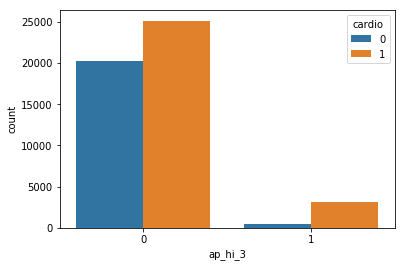

In [33]:
import seaborn as sns
sns.countplot(x=X['ap_hi_3'], hue=y)

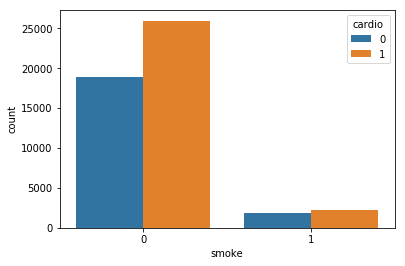

In [34]:

sns.countplot(X['smoke'], hue=y)